In [2]:
using ITensors

In [8]:
using Plots

In [59]:
using SparseArrays, LinearAlgebra, Arpack, LsqFit

In [5]:
function Calc_SvN(psi::MPS, b::Int64)
    # Orthogonalize the MPS at bond index b
    orthogonalize!(psi, b)

    # Perform Singular Value Decomposition (SVD)
    U, S, V = svd(psi[b], (linkind(psi, b-1), siteind(psi, b)))

    # Calculate von Neumann entropy
    SvN = 0.0
    for n = 1:dim(S, 1)
        p = S[n, n]^2
        SvN -= p * log(p)
    end

    return SvN
end;

In [6]:
function TFIM_DMRG(N::Int64, h::Float64, swp_num::Int64, maxM::Int64)
"""
    TFIM_DMRG(N::Int64, h::Float64, swp_num::Int64, maxM::Int64)

    Perform a Density Matrix Renormalization Group (DMRG) simulation for the Transverse Field Ising Model (TFIM) on a 1D chain.

    Parameters:
    - `N::Int64`: Number of sites in the 1D quantum system.
    - `h::Float64`: Transverse field strength in the TFIM Hamiltonian.
    - `swp_num::Int64`: Number of DMRG sweeps.
    - `maxM::Int64`: Maximum bond dimension.

    Returns:
    - `energy::Float64`: Ground state energy obtained from the DMRG simulation.
    - `psi::MPS`: Matrix Product State (MPS) representing the ground state of the quantum system after DMRG.
"""
    # Generate an index set representing quantum sites with spin S=1/2
    sites = siteinds("S=1/2", N)

    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the TFIM
    for j = 1:N
        if j < N
            # Interaction term between neighboring spins (Sz-Sz)
            ampo += -2.0, "Sz", j, "Sz", j + 1
        end
        # Transverse field term (Sx) at each site
        ampo += -h, "Sx", j
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)

    # Initialize the initial state to a random maxM=10 state 
    psi0 = randomMPS(sites,10)

    # Set up parameters for the DMRG (Density Matrix Renormalization Group) algorithm
    sweeps = Sweeps(swp_num)
    setmaxdim!(sweeps, maxM)
    setcutoff!(sweeps, 1E-16)

    # Perform the DMRG simulation to obtain the ground state energy and MPS representation
    energy, psi = dmrg(H, psi0, sweeps)

    return energy, psi
end;

In [7]:
N = 40
h = 0.1
swp_num = 20
maxM = 20
energy, psi = TFIM_DMRG(N, h, swp_num, maxM);

After sweep 1 energy=-19.552487159036072  maxlinkdim=20 maxerr=6.72E-11 time=24.199
After sweep 2 energy=-19.552534465172567  maxlinkdim=16 maxerr=2.54E-14 time=0.084
After sweep 3 energy=-19.552534465211917  maxlinkdim=3 maxerr=9.57E-17 time=0.055
After sweep 4 energy=-19.552534465211927  maxlinkdim=3 maxerr=6.63E-17 time=0.077
After sweep 5 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.046
After sweep 6 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.045
After sweep 7 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.055
After sweep 8 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.056
After sweep 9 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.083
After sweep 10 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.044
After sweep 11 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.048
After sweep 12 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.061
After swee

# 1. J1-J2 spin 1/2 chain

##     1. Heisenberg Hamiltonian construction for finite J2 term

Using

$\vec{S_{i}\cdot}\vec{S}_{j}=S_{i}^{z}S_{j}^{z}+\frac{1}{2}(S_{i}^{+}S_{j}^{-}+S_{i}^{-}S_{j}^{+})$

The hamiltonian gets the form

$ H=J_{1}\sum_{i}\vec{S_{i}\cdot}\vec{S}_{i+1}+J_{2}\sum_{i}\vec{S_{i}}\cdot\vec{S_{i+2}}$

$    =J_{1}\sum_{i}\left(S_{i}^{z}S_{i+1}^{z}+\frac{1}{2}(S_{i}^{+}S_{i+1}^{-}+S_{i}^{-}S_{i+1}^{+})\right)+J_{2}\sum_{i}\left(S_{i}^{z}S_{i+2}^{z}+\frac{1}{2}(S_{i}^{+}S_{i+2}^{-}+S_{i}^{-}S_{i+2}^{+})\right) $

Generalization of the method seen in class 6 for the MPO will lead to the matrices


$W_{(L)}=\left(\begin{array}{c}
I\\
S^{z}\\
S^{+}\\
S^{-}\\
0\\
0\\
0\\
0
\end{array}\right)$

$W_{(i)}=\left(\begin{array}{cccccccc}
I & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{z} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{+} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{-} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & I & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & I & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & I & 0 & 0 & 0 & 0\\
0 & J_{1}S^{z} & \frac{J_{1}}{2}S^{-} & \frac{J_{1}}{2}S^{+} & J_{2}S^{z} & \frac{J_{2}}{2}S^{-} & \frac{J_{2}}{2}S^{+} & I
\end{array}\right)$

$W_{(1)}=\left(\begin{array}{cccccccc}
0 & J_{1}S^{z} & \frac{J_{1}}{2}S^{-} & \frac{J_{1}}{2}S^{+} & J_{2}S^{z} & \frac{J_{2}}{2}S^{-} & \frac{J_{2}}{2}S^{+} & I\end{array}\right)$

In [44]:
function J1J2_DMRG(N::Int64, J1::Float64, J2::Float64, swp_num::Int64, maxM::Int64, QN_subspace::Int64)
    
    # Generate an index set representing quantum sites with spin S=1/2
    sites = siteinds("S=1/2", N; conserve_qns=true)

    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the TFIM
    for j = 1:N
        if j < N
            # Interaction term between neighboring spins (Sz-Sz)
            ampo += J1, "Sz", j, "Sz", j + 1
            ampo += J1/2, "S+", j, "S-", j + 1 
            ampo += J1/2, "S-", j, "S+", j + 1
        end
        if j < N-1
            # Interaction term between second neighboring spins (Sz-Sz)
            ampo += J2, "Sz", j, "Sz", j + 2
            ampo += J2/2, "S+", j, "S-", j + 2 
            ampo += J2/2, "S-", j, "S+", j + 2
        end 
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)

    # Initialize the initial state to a random maxM=10 state 
    #psi0 = randomMPS(sites,10)
    state= [isodd(n) ? "Up" : "Dn" for n=1:N]
    if QN_subspace == 1
        state[2]="Up"
    end
    psi0 = MPS(sites,state)
    
    # Set up parameters for the DMRG (Density Matrix Renormalization Group) algorithm
    sweeps = Sweeps(swp_num)
    setmaxdim!(sweeps, maxM)
    setcutoff!(sweeps, 1E-16)

    # Perform the DMRG simulation to obtain the ground state energy and MPS representation
    energy, psi = dmrg(H, psi0, sweeps)

    return energy, psi
end;

## 2. Finite size scaling

In [283]:
function finite_size_scaling(H_func,N_arr,g,swp_num,maxM,excited_subspace=1)
    delta_arr=[]
    J1=1.
    J2=g*J1
    for N in N_arr
        energy_s0, psi_0 = H_func(N, J1, J2, swp_num, maxM,0);
        energy_s_excited, psi_excited = H_func(N, J1, J2, swp_num, maxM,excited_subspace);
        push!(delta_arr, energy_s_excited-energy_s0)
    end
    return delta_arr
end;

In [278]:
N_arr= [ n for n in 20:20:100];
swp_num = 10
maxM = 100;

In [279]:
g_arr=[0 ,0.241, 0.48]
deltas_g_arr=[]
for g in g_arr
    push!(deltas_g_arr,finite_size_scaling(J1J2_DMRG,N_arr,g,swp_num,maxM))
end;

After sweep 1 energy=-8.60514183065435  maxlinkdim=4 maxerr=0.00E+00 time=0.538
After sweep 2 energy=-8.681922609869904  maxlinkdim=16 maxerr=0.00E+00 time=3.395
After sweep 3 energy=-8.682473323653621  maxlinkdim=64 maxerr=8.77E-17 time=0.557
After sweep 4 energy=-8.68247333439891  maxlinkdim=99 maxerr=9.81E-17 time=0.868
After sweep 5 energy=-8.682473334398972  maxlinkdim=97 maxerr=1.04E-16 time=0.610
After sweep 6 energy=-8.682473334398976  maxlinkdim=97 maxerr=8.94E-17 time=0.387
After sweep 7 energy=-8.682473334398955  maxlinkdim=97 maxerr=8.94E-17 time=0.302
After sweep 8 energy=-8.682473334398965  maxlinkdim=97 maxerr=8.94E-17 time=0.286
After sweep 9 energy=-8.682473334398964  maxlinkdim=97 maxerr=8.94E-17 time=0.351
After sweep 10 energy=-8.68247333439896  maxlinkdim=97 maxerr=8.94E-17 time=0.348
After sweep 1 energy=-7.910060820117726  maxlinkdim=4 maxerr=0.00E+00 time=0.046
After sweep 2 energy=-8.479555924186457  maxlinkdim=16 maxerr=0.00E+00 time=0.146
After sweep 3 energy

After sweep 10 energy=-44.08729916754671  maxlinkdim=100 maxerr=1.76E-10 time=2.522
After sweep 1 energy=-7.893031868110662  maxlinkdim=4 maxerr=0.00E+00 time=0.056
After sweep 2 energy=-7.94944575912862  maxlinkdim=16 maxerr=0.00E+00 time=0.123
After sweep 3 energy=-7.94978613502113  maxlinkdim=64 maxerr=9.98E-17 time=0.239
After sweep 4 energy=-7.949786241657115  maxlinkdim=100 maxerr=6.60E-16 time=0.393
After sweep 5 energy=-7.949786241662649  maxlinkdim=100 maxerr=2.41E-16 time=0.419
After sweep 6 energy=-7.949786241662642  maxlinkdim=100 maxerr=1.70E-16 time=0.411
After sweep 7 energy=-7.949786241662626  maxlinkdim=100 maxerr=1.70E-16 time=0.424
After sweep 8 energy=-7.949786241662648  maxlinkdim=100 maxerr=1.70E-16 time=0.436
After sweep 9 energy=-7.949786241662641  maxlinkdim=100 maxerr=1.70E-16 time=0.425
After sweep 10 energy=-7.949786241662631  maxlinkdim=100 maxerr=1.70E-16 time=0.448
After sweep 1 energy=-7.267425336676245  maxlinkdim=4 maxerr=0.00E+00 time=0.058
After swee

After sweep 9 energy=-40.06545406548293  maxlinkdim=100 maxerr=8.84E-11 time=4.262
After sweep 10 energy=-40.06553217396506  maxlinkdim=100 maxerr=5.58E-11 time=4.371
After sweep 1 energy=-7.49616712208073  maxlinkdim=4 maxerr=0.00E+00 time=0.050
After sweep 2 energy=-7.503861902049232  maxlinkdim=16 maxerr=0.00E+00 time=0.143
After sweep 3 energy=-7.503869774420087  maxlinkdim=64 maxerr=7.84E-17 time=0.206
After sweep 4 energy=-7.503869788818607  maxlinkdim=100 maxerr=3.64E-16 time=0.359
After sweep 5 energy=-7.503869788823641  maxlinkdim=91 maxerr=2.01E-16 time=0.392
After sweep 6 energy=-7.503869788823639  maxlinkdim=86 maxerr=9.98E-17 time=0.390
After sweep 7 energy=-7.503869788823646  maxlinkdim=86 maxerr=9.94E-17 time=0.396
After sweep 8 energy=-7.503869788823656  maxlinkdim=86 maxerr=9.94E-17 time=0.380
After sweep 9 energy=-7.503869788823648  maxlinkdim=86 maxerr=9.94E-17 time=0.438
After sweep 10 energy=-7.503869788823638  maxlinkdim=86 maxerr=9.94E-17 time=0.419
After sweep 1

After sweep 8 energy=-37.30391943337031  maxlinkdim=100 maxerr=4.45E-11 time=4.335
After sweep 9 energy=-37.30837316989935  maxlinkdim=100 maxerr=6.28E-11 time=4.361
After sweep 10 energy=-37.31212928522433  maxlinkdim=100 maxerr=8.88E-11 time=4.838


For g=0:

In [301]:
g=0
x = 1 ./ N_arr
y = deltas_g_arr[1]

fun(x, a) = a[1] .+ a[2]*x
res = LsqFit.curve_fit(fun, x, y, [0., 0.]);

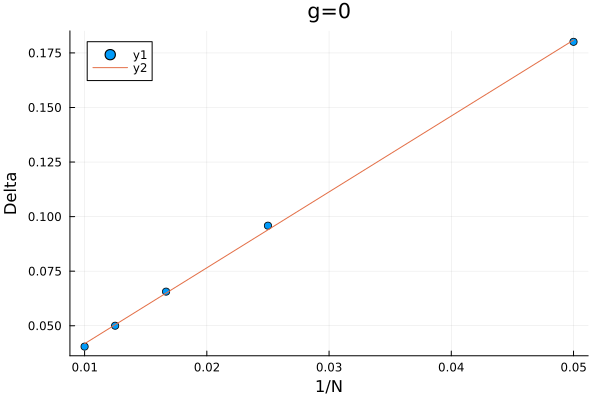

In [302]:
scatter(x, y,linestyle = :dot,title="g=0",xlabel="1/N",ylabel= "Delta")
plot!(x, fun(x, coef(res)))

In [303]:
intercept=coef(res)[1]
println("The intercept for g=0 is $intercept")

The intercept for g=0 is 0.006985882985487524


Which is pretty close to zero, indicating the system is gapless as expected

For g=g_c=0.241

In [304]:
g=0.241
x = 1 ./ N_arr
y = deltas_g_arr[2]

fun(x, a) = a[1] .+ a[2]*x
res = LsqFit.curve_fit(fun, x, y, [0., 0.]);

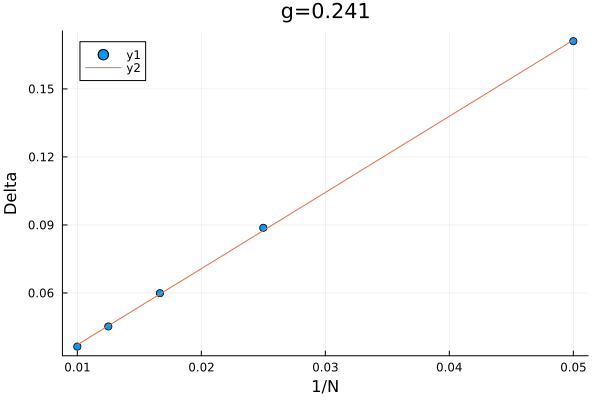

In [305]:
scatter(x, y,linestyle = :dot,title="g=0.241",xlabel="1/N",ylabel= "Delta")
plot!(x, fun(x, coef(res)))

In [306]:
intercept=coef(res)[1]
println("The intercept for g=0 is $intercept")

The intercept for g=0 is 0.003511926213340998


Which is pretty close to zero, indicating the system is gapless as expected for still being in the phase with g below gc

For g=0.48:

In [316]:
g=0.48
x = 1 ./ N_arr
y = deltas_g_arr[3]

fun(x, a) = a[1] .+ a[2]*x .+ a[3]*(x.^2)
#fun(x, a) = a[1] .+ a[3]*(x.^2)
res = LsqFit.curve_fit(fun, x, y, [0., 0., 0.]);

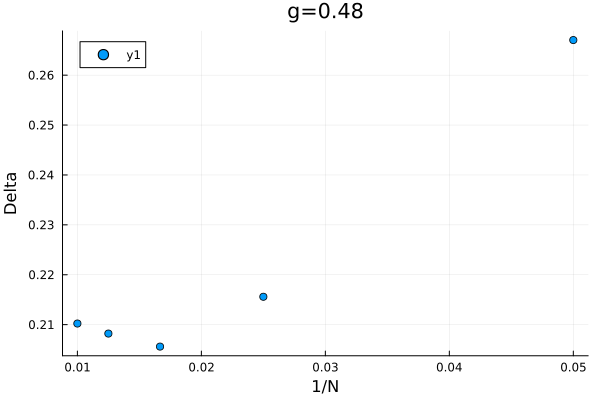

In [319]:
scatter(x, y,linestyle = :dot,title="g=0.48",xlabel="1/N",ylabel= "Delta")
#plot!(x, fun(x, coef(res)))

Here we can see an obvious finite gap as expected from being deep in the dimerized phase, as the intercept with the y axis is non-zero.

## 3. Spin-spin correlations

In [291]:
x_arr= [x for x in 1:200];

In [292]:
N = 200
swp_num = 10
maxM = 100
J1=1.0;

For g=0:

In [293]:
g=0.
energy_s0_g0, psi_0_g0 = J1J2_DMRG(N, J1,J1*g , swp_num, maxM,0)
corr_mat_g0 = correlation_matrix(psi_0_g0,"Sz","Sz");

After sweep 1 energy=-87.90732132925154  maxlinkdim=4 maxerr=0.00E+00 time=0.569
After sweep 2 energy=-88.40009736494895  maxlinkdim=16 maxerr=0.00E+00 time=1.187
After sweep 3 energy=-88.4367923683276  maxlinkdim=64 maxerr=9.54E-17 time=1.907
After sweep 4 energy=-88.44026222450567  maxlinkdim=100 maxerr=3.54E-11 time=4.049
After sweep 5 energy=-88.4412149980951  maxlinkdim=100 maxerr=3.27E-10 time=5.070
After sweep 6 energy=-88.44152457900702  maxlinkdim=100 maxerr=2.73E-09 time=5.004
After sweep 7 energy=-88.44155419065386  maxlinkdim=100 maxerr=3.52E-09 time=5.250
After sweep 8 energy=-88.44155471067545  maxlinkdim=100 maxerr=2.85E-09 time=6.090
After sweep 9 energy=-88.44155471372999  maxlinkdim=100 maxerr=2.80E-09 time=4.955
After sweep 10 energy=-88.44155471369858  maxlinkdim=100 maxerr=2.81E-09 time=5.439


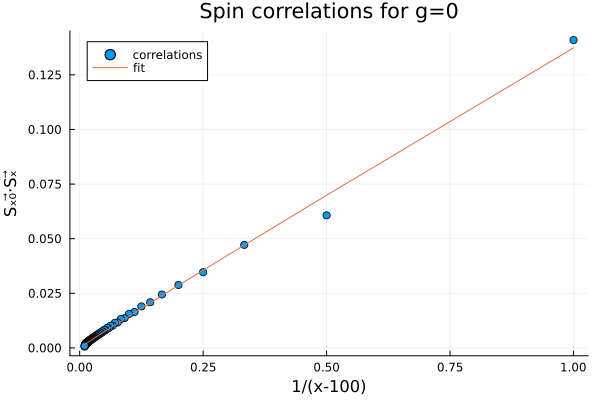

In [244]:
x = 1 ./ (x_arr[101:end] .- 100)
y = abs.(corr_mat_g0[100,101:end])

fun(x, a) = a[1].*(x.^a[2])
res = LsqFit.curve_fit(fun, x, y, [0.,0.]);
scatter(x,y,xlabel="1/(x-100)",ylabel="Sₓ₀⃗⋅Sₓ⃗",title="Spin correlations for g=0",label="correlations")
plot!(x , fun(x, coef(res)),label="fit")

In [245]:
α_g0=coef(res)[2]
println("The exponent α for g=0 was found from the fit to be $α_g0")

The exponent α for g=0 was found from the fit to be 0.9747021037694494


For g=g_c=0.241

In [240]:
g=0.241
energy_s0_gc, psi_0_gc = J1J2_DMRG(N, J1, J1*g, swp_num, maxM,0)
corr_mat_gc = correlation_matrix(psi_0_gc,"Sz","Sz");

After sweep 1 energy=-79.85921543022567  maxlinkdim=4 maxerr=0.00E+00 time=1.408
After sweep 2 energy=-80.26699841583698  maxlinkdim=16 maxerr=0.00E+00 time=1.709
After sweep 3 energy=-80.29225473086893  maxlinkdim=64 maxerr=9.76E-17 time=3.316
After sweep 4 energy=-80.29554791426227  maxlinkdim=100 maxerr=1.74E-11 time=10.862
After sweep 5 energy=-80.29686267966746  maxlinkdim=100 maxerr=9.10E-11 time=10.304
After sweep 6 energy=-80.297547509049  maxlinkdim=100 maxerr=9.18E-11 time=9.237
After sweep 7 energy=-80.29800930601232  maxlinkdim=100 maxerr=3.59E-10 time=10.028
After sweep 8 energy=-80.2981796706352  maxlinkdim=100 maxerr=5.79E-10 time=13.515
After sweep 9 energy=-80.2982279430498  maxlinkdim=100 maxerr=4.67E-09 time=15.811
After sweep 10 energy=-80.29823344141123  maxlinkdim=100 maxerr=4.83E-09 time=10.141


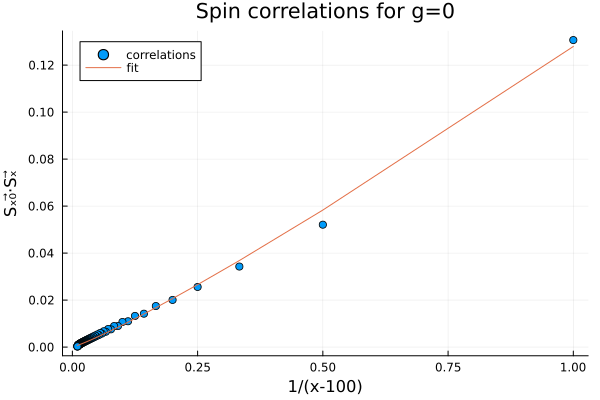

In [246]:
x = 1 ./ (x_arr[101:end] .- 100)
y = abs.(corr_mat_gc[100,101:end])

fun(x, a) = a[1].*(x.^a[2])
res = LsqFit.curve_fit(fun, x, y, [0.,0.]);
scatter(x,y,xlabel="1/(x-100)",ylabel="Sₓ₀⃗⋅Sₓ⃗",title="Spin correlations for g=0",label="correlations")
plot!(x , fun(x, coef(res)),label="fit")

In [247]:
α_gc=coef(res)[2]
println("The exponent α for g=gc was found from the fit to be $α_gc")

The exponent α for g=gc was found from the fit to be 1.1334175486507352


For g=0.48:

In [106]:
g=0.48
energy_s0_gbig, psi_0_gbig = J1J2_DMRG(N, J1, J1*g, swp_num, maxM,0)
corr_mat_gbig = correlation_matrix(psi_0_gbig,"Sz","Sz");

After sweep 1 energy=-74.86128782590902  maxlinkdim=4 maxerr=0.00E+00 time=1.156
After sweep 2 energy=-75.04518564982467  maxlinkdim=16 maxerr=0.00E+00 time=2.533
After sweep 3 energy=-75.04545075719118  maxlinkdim=64 maxerr=9.99E-17 time=3.322
After sweep 4 energy=-75.04545397642252  maxlinkdim=100 maxerr=2.90E-15 time=8.713
After sweep 5 energy=-75.04545451340503  maxlinkdim=100 maxerr=2.56E-14 time=9.508
After sweep 6 energy=-75.04545469548424  maxlinkdim=100 maxerr=3.99E-15 time=9.114
After sweep 7 energy=-75.04545473347615  maxlinkdim=100 maxerr=2.13E-15 time=8.832
After sweep 8 energy=-75.04545474049236  maxlinkdim=100 maxerr=5.53E-15 time=9.522
After sweep 9 energy=-75.04545474163356  maxlinkdim=100 maxerr=3.11E-15 time=9.080
After sweep 10 energy=-75.0454547417934  maxlinkdim=100 maxerr=2.78E-15 time=10.233


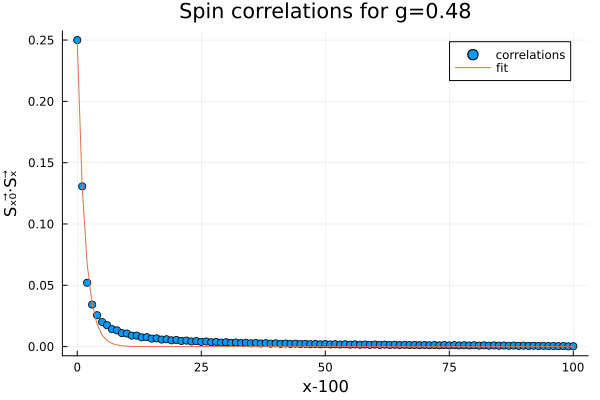

In [260]:
x = x_arr[100:end] .- 100
y = abs.(corr_mat_gc[100,100:end])

fun(x, a) = a[1].*(exp.(-x./a[2]))
res = LsqFit.curve_fit(fun, x, y, [4.,3.5]);
scatter(x,y,xlabel="x-100",ylabel="Sₓ₀⃗⋅Sₓ⃗",title="Spin correlations for g=0.48",label="correlations")
plot!(x , fun(x, coef(res)),label="fit")

In [259]:
α_gbig=coef(res)[2]
println("The correlation length ζ for g=0.48 was found from the fit to be $α_gbig")

The correlation length ζ for g=0.48 was found from the fit to be 1.5303231300280302


The fit is not very good though.

# 2. spin-1 - Haldane gap

In [263]:
function bilinear_biquadtatic_DMRG(N::Int64, J1::Float64, J2::Float64, swp_num::Int64, maxM::Int64, QN_subspace::Int64)
    
    # Generate an index set representing quantum sites with spin S=1/2
    sites = siteinds("S=1", N; conserve_qns=true)

    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the TFIM
    for j = 1:N-1
        # Interaction term between neighboring spins (Sz-Sz)
        ampo += J1, "Sz", j, "Sz", j + 1
        ampo += J1/2, "S+", j, "S-", j + 1
        ampo += J1/2, "S-", j, "S+", j + 1
        
        #J2 
        ampo += J2, "Sz", j, "Sz", j + 1, "Sz", j, "Sz", j + 1
        ampo += J2/4, "S+", j, "S-", j + 1, "S-", j, "S+", j + 1
        ampo += J2/4, "S-", j, "S+", j + 1, "S+", j, "S-", j + 1
        ampo += J2/4, "S+", j, "S-", j + 1, "S+", j, "S-", j + 1
        ampo += J2/4, "S-", j, "S+", j + 1, "S-", j, "S+", j + 1
        ampo += J1/2, "S-", j, "S+", j + 1, "Sz", j, "Sz", j + 1
        ampo += J1/2, "S+", j, "S-", j + 1, "Sz", j, "Sz", j + 1
        ampo += J1/2, "Sz", j, "Sz", j + 1, "S-", j, "S+", j + 1
        ampo += J1/2, "Sz", j, "Sz", j + 1, "S+", j, "S-", j + 1
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)

    # Initialize the initial state to a random maxM=10 state 
    # psi0 = randomMPS(sites,10)
    state= [isodd(n) ? "Up" : "Dn" for n=1:N]
    if QN_subspace == 1
        state[2]="Up"
    end
    if QN_subspace == 2
        state[2]="Up"
        state[4]="Up"
    end
    psi0 = MPS(sites,state)
    # Set up parameters for the DMRG (Density Matrix Renormalization Group) algorithm
    sweeps = Sweeps(swp_num)
    setmaxdim!(sweeps, maxM)
    setcutoff!(sweeps, 1E-16)

    # Perform the DMRG simulation to obtain the ground state energy and MPS representation
    energy, psi = dmrg(H, psi0, sweeps)

    return energy, psi
end;

## 1. System gap for J2 between 0 and 1/3

In [280]:
N_arr= [ n for n in 20:20:100];
swp_num = 10
maxM = 100;

In [298]:
J2_arr=[ j for j in 0:1/12:1/3];

5-element Vector{Float64}:
 0.0
 0.08333333333333333
 0.16666666666666666
 0.25
 0.3333333333333333

In [299]:
deltas_arr=[]
for g in J2_arr
    push!(deltas_arr,finite_size_scaling(bilinear_biquadtatic_DMRG,N_arr,g,swp_num,maxM,2))
end;

After sweep 1 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.021
After sweep 2 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.022
After sweep 3 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.022
After sweep 4 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.022
After sweep 5 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.022
After sweep 6 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.023
After sweep 7 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.030
After sweep 8 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.031
After sweep 9 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.034
After sweep 10 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.032
After sweep 1 energy=-11.0  maxlinkdim=1 maxerr=0.00E+00 time=0.020
After sweep 2 energy=-11.0  maxlinkdim=1 maxerr=0.00E+00 time=0.021
After sweep 3 energy=-11.0  maxlinkdim=1 maxerr=0.00E+00 time=0.020
After sweep 4 energy=-11.0  maxlinkdim=1 maxerr=0.00E+00 time=0.024
After sweep 5 energy=-11.0  maxlinkdim=1 maxerr

After sweep 8 energy=-10.533888296002347  maxlinkdim=100 maxerr=3.30E-16 time=0.436
After sweep 9 energy=-10.534105854914028  maxlinkdim=100 maxerr=2.82E-16 time=0.406
After sweep 10 energy=-10.53418983119605  maxlinkdim=100 maxerr=2.55E-16 time=0.433
After sweep 1 energy=-32.5742385083754  maxlinkdim=4 maxerr=1.97E-33 time=0.119
After sweep 2 energy=-32.5742385474574  maxlinkdim=9 maxerr=9.82E-17 time=0.245
After sweep 3 energy=-32.57423854745771  maxlinkdim=8 maxerr=9.42E-17 time=0.280
After sweep 4 energy=-32.574238547457675  maxlinkdim=8 maxerr=7.11E-17 time=0.282
After sweep 5 energy=-32.57423854745764  maxlinkdim=8 maxerr=7.11E-17 time=0.292
After sweep 6 energy=-32.574238547457696  maxlinkdim=8 maxerr=7.11E-17 time=0.244
After sweep 7 energy=-32.574238547457654  maxlinkdim=8 maxerr=7.11E-17 time=0.293
After sweep 8 energy=-32.57423854745765  maxlinkdim=8 maxerr=7.11E-17 time=0.285
After sweep 9 energy=-32.574238547457696  maxlinkdim=8 maxerr=7.11E-17 time=0.296
After sweep 10 en

After sweep 8 energy=-8.126695602593188  maxlinkdim=100 maxerr=8.26E-16 time=0.380
After sweep 9 energy=-8.126700009657126  maxlinkdim=100 maxerr=4.15E-16 time=0.395
After sweep 10 energy=-8.12670076932463  maxlinkdim=96 maxerr=1.04E-16 time=0.401
After sweep 1 energy=-26.30992988263215  maxlinkdim=4 maxerr=2.11E-33 time=0.121
After sweep 2 energy=-26.309932945747303  maxlinkdim=11 maxerr=9.97E-17 time=0.323
After sweep 3 energy=-26.30993294583624  maxlinkdim=13 maxerr=9.55E-17 time=0.281
After sweep 4 energy=-26.309932945836284  maxlinkdim=14 maxerr=9.73E-17 time=0.336
After sweep 5 energy=-26.309932945836273  maxlinkdim=14 maxerr=9.49E-17 time=0.384
After sweep 6 energy=-26.30993294583625  maxlinkdim=14 maxerr=9.49E-17 time=0.430
After sweep 7 energy=-26.30993294583623  maxlinkdim=14 maxerr=9.49E-17 time=0.462
After sweep 8 energy=-26.309932945836245  maxlinkdim=14 maxerr=9.49E-17 time=0.414
After sweep 9 energy=-26.30993294583625  maxlinkdim=14 maxerr=9.49E-17 time=0.393
After sweep

After sweep 8 energy=-5.781188992655594  maxlinkdim=89 maxerr=9.97E-17 time=0.412
After sweep 9 energy=-5.78118899604119  maxlinkdim=65 maxerr=9.90E-17 time=0.277
After sweep 10 energy=-5.78118899614446  maxlinkdim=59 maxerr=9.95E-17 time=0.257
After sweep 1 energy=-20.228181844869283  maxlinkdim=4 maxerr=2.24E-33 time=0.146
After sweep 2 energy=-20.228224383203067  maxlinkdim=14 maxerr=9.95E-17 time=0.297
After sweep 3 energy=-20.22822438731896  maxlinkdim=20 maxerr=9.84E-17 time=0.353
After sweep 4 energy=-20.228224387318978  maxlinkdim=20 maxerr=9.87E-17 time=0.378
After sweep 5 energy=-20.228224387318885  maxlinkdim=20 maxerr=9.89E-17 time=0.398
After sweep 6 energy=-20.228224387318924  maxlinkdim=20 maxerr=9.89E-17 time=0.395
After sweep 7 energy=-20.22822438731896  maxlinkdim=20 maxerr=9.89E-17 time=0.374
After sweep 8 energy=-20.228224387318924  maxlinkdim=20 maxerr=9.89E-17 time=0.400
After sweep 9 energy=-20.228224387318946  maxlinkdim=20 maxerr=9.90E-17 time=0.413
After sweep

After sweep 8 energy=-3.500560528931118  maxlinkdim=58 maxerr=9.47E-17 time=0.229
After sweep 9 energy=-3.5005605289311075  maxlinkdim=57 maxerr=9.57E-17 time=0.237
After sweep 10 energy=-3.5005605289311195  maxlinkdim=57 maxerr=9.40E-17 time=0.242
After sweep 1 energy=-14.352037650198834  maxlinkdim=4 maxerr=2.34E-33 time=0.161
After sweep 2 energy=-14.352327982139059  maxlinkdim=15 maxerr=3.97E-17 time=0.340
After sweep 3 energy=-14.352328063713383  maxlinkdim=28 maxerr=9.71E-17 time=0.364
After sweep 4 energy=-14.352328063713571  maxlinkdim=27 maxerr=9.98E-17 time=0.413
After sweep 5 energy=-14.352328063713554  maxlinkdim=27 maxerr=9.95E-17 time=0.425
After sweep 6 energy=-14.3523280637136  maxlinkdim=27 maxerr=9.85E-17 time=0.369
After sweep 7 energy=-14.352328063713589  maxlinkdim=27 maxerr=9.85E-17 time=0.382
After sweep 8 energy=-14.352328063713573  maxlinkdim=27 maxerr=9.85E-17 time=0.366
After sweep 9 energy=-14.352328063713603  maxlinkdim=27 maxerr=9.85E-17 time=0.378
After s

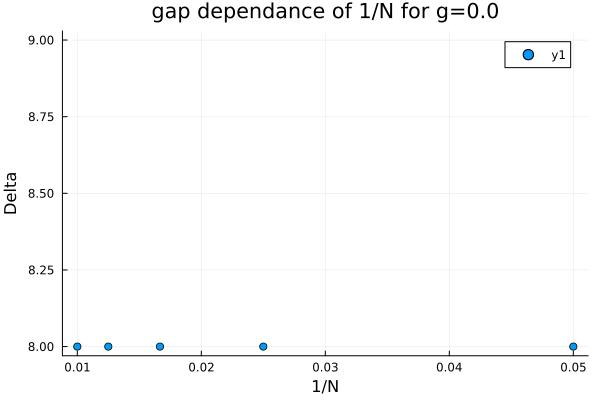

In [333]:
i=1
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

scatter(x, y,linestyle = :dot,title="gap dependance of 1/N for g=$g",xlabel="1/N",ylabel= "Delta")

For g=0 we found the gap is constant- finite and non zero and equals 8.

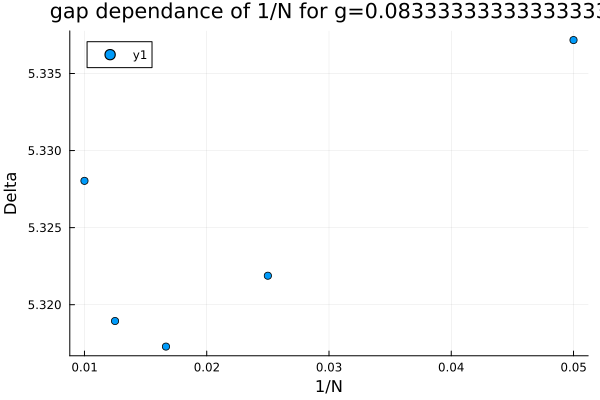

In [342]:
i=2
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

scatter(x, y,linestyle = :dot,title="gap dependance of 1/N for g=$g",xlabel="1/N",ylabel= "Delta")

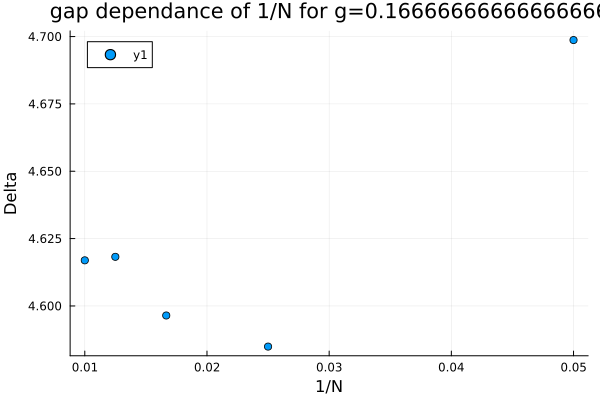

In [343]:
i=3
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

scatter(x, y,linestyle = :dot,title="gap dependance of 1/N for g=$g",xlabel="1/N",ylabel= "Delta")

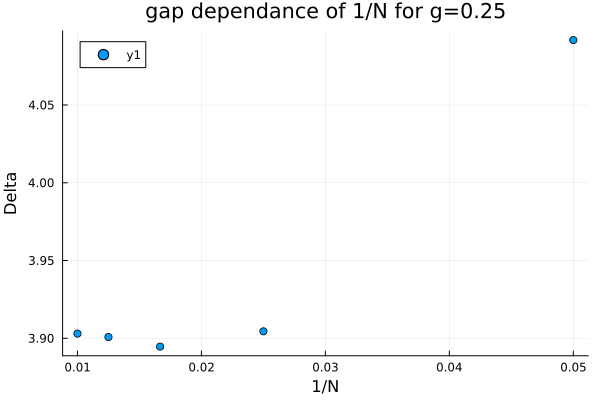

In [344]:
i=4
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

scatter(x, y,linestyle = :dot,title="gap dependance of 1/N for g=$g",xlabel="1/N",ylabel= "Delta")

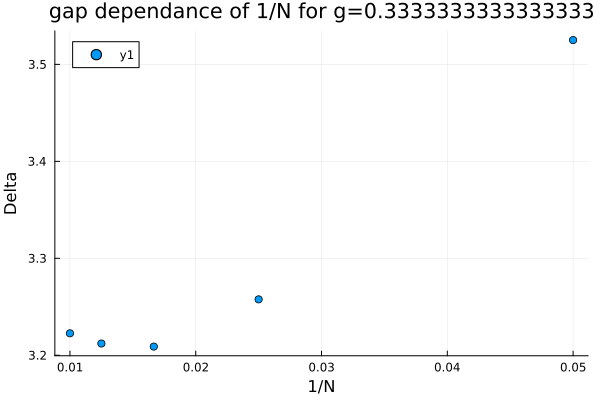

In [345]:
i=5
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

scatter(x, y,linestyle = :dot,title="gap dependance of 1/N for g=$g",xlabel="1/N",ylabel= "Delta")

We see that for all J2 between 0 and 1/3 the energy gap is finite and non zero.

### 2.a Energy gaps between the ground states of S=0 and S=1 subspaces. For J2 between 0 and 1/3

In [346]:
deltas_arr=[]
for g in J2_arr
    push!(deltas_arr,finite_size_scaling(bilinear_biquadtatic_DMRG,N_arr,g,swp_num,maxM,1))
end;

After sweep 1 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.020
After sweep 2 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.023
After sweep 3 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.024
After sweep 4 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.023
After sweep 5 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.028
After sweep 6 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.026
After sweep 7 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.028
After sweep 8 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.025
After sweep 9 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.027
After sweep 10 energy=-19.0  maxlinkdim=1 maxerr=0.00E+00 time=0.029
After sweep 1 energy=-15.0  maxlinkdim=1 maxerr=0.00E+00 time=0.018
After sweep 2 energy=-15.0  maxlinkdim=1 maxerr=0.00E+00 time=0.023
After sweep 3 energy=-15.0  maxlinkdim=1 maxerr=0.00E+00 time=0.020
After sweep 4 energy=-15.0  maxlinkdim=1 maxerr=0.00E+00 time=0.020
After sweep 5 energy=-15.0  maxlinkdim=1 maxerr

After sweep 8 energy=-14.110480315785258  maxlinkdim=89 maxerr=9.59E-17 time=0.369
After sweep 9 energy=-14.111038613884359  maxlinkdim=90 maxerr=9.64E-17 time=0.384
After sweep 10 energy=-14.111420427642518  maxlinkdim=89 maxerr=9.41E-17 time=0.425
After sweep 1 energy=-32.5742385083754  maxlinkdim=4 maxerr=1.97E-33 time=0.145
After sweep 2 energy=-32.5742385474574  maxlinkdim=9 maxerr=9.82E-17 time=0.308
After sweep 3 energy=-32.57423854745771  maxlinkdim=8 maxerr=9.42E-17 time=0.298
After sweep 4 energy=-32.574238547457675  maxlinkdim=8 maxerr=7.11E-17 time=0.284
After sweep 5 energy=-32.57423854745764  maxlinkdim=8 maxerr=7.11E-17 time=0.282
After sweep 6 energy=-32.574238547457696  maxlinkdim=8 maxerr=7.11E-17 time=0.305
After sweep 7 energy=-32.574238547457654  maxlinkdim=8 maxerr=7.11E-17 time=0.281
After sweep 8 energy=-32.57423854745765  maxlinkdim=8 maxerr=7.11E-17 time=0.286
After sweep 9 energy=-32.574238547457696  maxlinkdim=8 maxerr=7.11E-17 time=0.274
After sweep 10 ener

After sweep 8 energy=-11.300986674301615  maxlinkdim=100 maxerr=1.19E-15 time=0.406
After sweep 9 energy=-11.301035947896322  maxlinkdim=100 maxerr=3.51E-16 time=0.456
After sweep 10 energy=-11.301051058569193  maxlinkdim=100 maxerr=1.69E-16 time=0.396
After sweep 1 energy=-26.30992988263215  maxlinkdim=4 maxerr=2.11E-33 time=0.118
After sweep 2 energy=-26.309932945747303  maxlinkdim=11 maxerr=9.97E-17 time=0.290
After sweep 3 energy=-26.30993294583624  maxlinkdim=13 maxerr=9.55E-17 time=0.309
After sweep 4 energy=-26.309932945836284  maxlinkdim=14 maxerr=9.73E-17 time=0.342
After sweep 5 energy=-26.309932945836273  maxlinkdim=14 maxerr=9.49E-17 time=0.350
After sweep 6 energy=-26.30993294583625  maxlinkdim=14 maxerr=9.49E-17 time=0.367
After sweep 7 energy=-26.30993294583623  maxlinkdim=14 maxerr=9.49E-17 time=0.358
After sweep 8 energy=-26.309932945836245  maxlinkdim=14 maxerr=9.49E-17 time=0.346
After sweep 9 energy=-26.30993294583625  maxlinkdim=14 maxerr=9.49E-17 time=0.352
After 

After sweep 8 energy=-8.575521933406023  maxlinkdim=100 maxerr=4.62E-16 time=0.380
After sweep 9 energy=-8.575523461200206  maxlinkdim=98 maxerr=1.22E-16 time=0.379
After sweep 10 energy=-8.575523622177585  maxlinkdim=89 maxerr=9.94E-17 time=0.347
After sweep 1 energy=-20.228181844869283  maxlinkdim=4 maxerr=2.24E-33 time=0.145
After sweep 2 energy=-20.228224383203067  maxlinkdim=14 maxerr=9.95E-17 time=0.289
After sweep 3 energy=-20.22822438731896  maxlinkdim=20 maxerr=9.84E-17 time=0.400
After sweep 4 energy=-20.228224387318978  maxlinkdim=20 maxerr=9.87E-17 time=0.389
After sweep 5 energy=-20.228224387318885  maxlinkdim=20 maxerr=9.89E-17 time=0.383
After sweep 6 energy=-20.228224387318924  maxlinkdim=20 maxerr=9.89E-17 time=0.384
After sweep 7 energy=-20.22822438731896  maxlinkdim=20 maxerr=9.89E-17 time=0.382
After sweep 8 energy=-20.228224387318924  maxlinkdim=20 maxerr=9.89E-17 time=0.355
After sweep 9 energy=-20.228224387318946  maxlinkdim=20 maxerr=9.90E-17 time=0.347
After sw

After sweep 8 energy=-5.94452273868157  maxlinkdim=57 maxerr=9.95E-17 time=0.286
After sweep 9 energy=-5.944522738700457  maxlinkdim=42 maxerr=9.97E-17 time=0.192
After sweep 10 energy=-5.944522738700462  maxlinkdim=40 maxerr=9.92E-17 time=0.210
After sweep 1 energy=-14.352037650198834  maxlinkdim=4 maxerr=2.34E-33 time=0.140
After sweep 2 energy=-14.352327982139059  maxlinkdim=15 maxerr=3.97E-17 time=0.312
After sweep 3 energy=-14.352328063713383  maxlinkdim=28 maxerr=9.71E-17 time=0.397
After sweep 4 energy=-14.352328063713571  maxlinkdim=27 maxerr=9.98E-17 time=0.432
After sweep 5 energy=-14.352328063713554  maxlinkdim=27 maxerr=9.95E-17 time=0.397
After sweep 6 energy=-14.3523280637136  maxlinkdim=27 maxerr=9.85E-17 time=0.388
After sweep 7 energy=-14.352328063713589  maxlinkdim=27 maxerr=9.85E-17 time=0.397
After sweep 8 energy=-14.352328063713573  maxlinkdim=27 maxerr=9.85E-17 time=0.387
After sweep 9 energy=-14.352328063713603  maxlinkdim=27 maxerr=9.85E-17 time=0.439
After swee

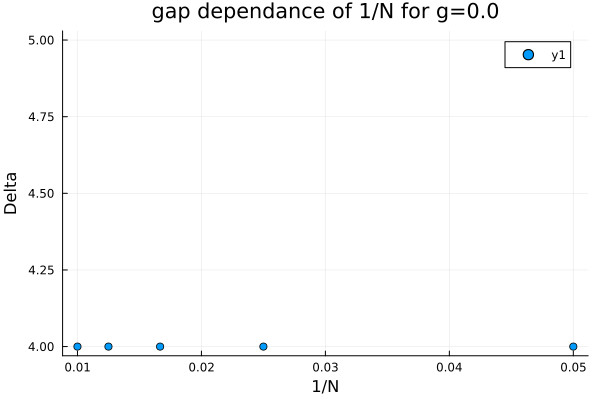

In [347]:
i=1
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

scatter(x, y,linestyle = :dot,title="gap between gst of S=0 and S=1 dependance of 1/N for g=$g",xlabel="1/N",ylabel= "Delta")

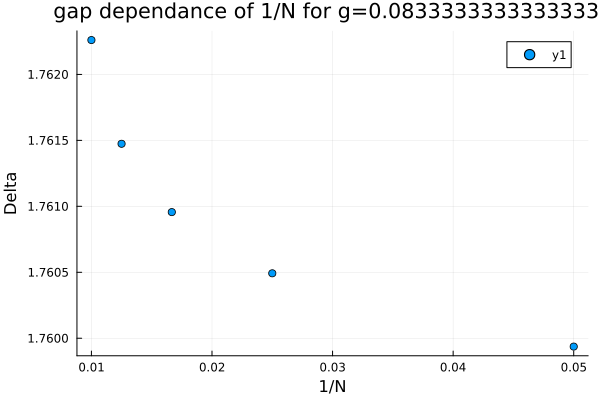

In [348]:
i=2
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

scatter(x, y,linestyle = :dot,title="gap between gst of S=0 and S=1 dependance of 1/N for g=$g",xlabel="1/N",ylabel= "Delta")

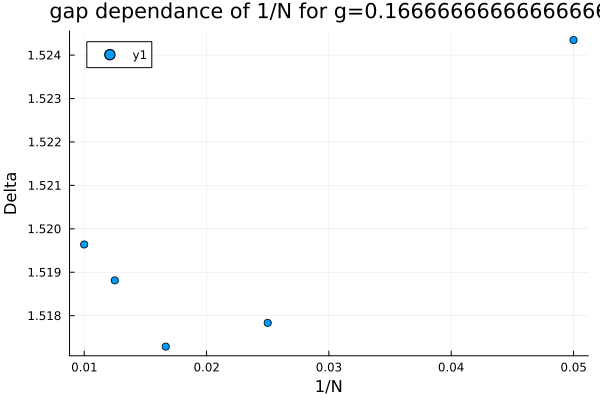

In [349]:
i=3
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

scatter(x, y,linestyle = :dot,title="gap between gst of S=0 and S=1 dependance of 1/N for g=$g",xlabel="1/N",ylabel= "Delta")

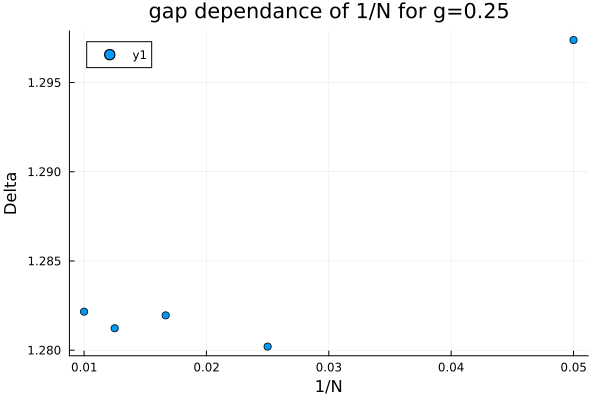

In [350]:
i=4
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

scatter(x, y,linestyle = :dot,title="gap between gst of S=0 and S=1 dependance of 1/N for g=$g",xlabel="1/N",ylabel= "Delta")

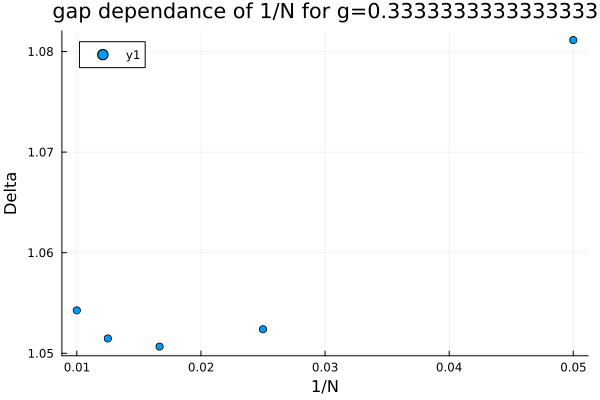

In [351]:
i=5
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

scatter(x, y,linestyle = :dot,title="gap between gst of S=0 and S=1 dependance of 1/N for g=$g",xlabel="1/N",ylabel= "Delta")

### 2.b Local expectation value of Sz along the chain